In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import SimpleImputer

df=pd.read_csv("water_safety_pond_data.csv")
df.info()

C:\Users\kaout\AppData\Local\Temp\ipykernel_43524\3986584918.py:9: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("water_safety_pond_data.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905803 entries, 0 to 905802
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   timestamp           905803 non-null  object 
 1   entry_id            905803 non-null  float64
 2   temperature         905803 non-null  float64
 3   turbidity           905803 non-null  float64
 4   dissolved_oxygen    905803 non-null  float64
 5   ph                  905803 non-null  float64
 6   ammonia             905713 non-null  float64
 7   nitrate             905803 non-null  float64
 8   population          612530 non-null  float64
 9   fish_length         905803 non-null  object 
 10  fish_weight         905803 non-null  float64
 11  water_safety_score  905803 non-null  float64
 12  safety_category     905803 non-null  object 
 13  source_df           905803 non-null  int64  
dtypes: float64(10), int64(1), object(3)
memory usage: 96.8+ MB


In [2]:
df["safety_category"].unique()

array(['SAFE', 'CRITICAL', 'WARNING', 'DANGER'], dtype=object)

In [3]:
#analyze null values
print(df.isnull().sum())
print(f"\nTotal rows: {len(df)}")
print(f"Population null count: {df['population'].isnull().sum()}")
print(f"Population null percentage: {(df['population'].isnull().sum() / len(df)) * 100:.2f}%")

timestamp                  0
entry_id                   0
temperature                0
turbidity                  0
dissolved_oxygen           0
ph                         0
ammonia                   90
nitrate                    0
population            293273
fish_length                0
fish_weight                0
water_safety_score         0
safety_category            0
source_df                  0
dtype: int64

Total rows: 905803
Population null count: 293273
Population null percentage: 32.38%


In [4]:
print(df['timestamp'])

0         2021-06-19 00:00:05 CET
1         2021-06-19 00:01:02 CET
2         2021-06-19 00:01:22 CET
3         2021-06-19 00:01:44 CET
4         2021-06-19 00:02:07 CET
                   ...           
905798                 16/01/2022
905799                 16/01/2022
905800                 16/01/2022
905801                 16/01/2022
905802                 16/01/2022
Name: timestamp, Length: 905803, dtype: object


In [5]:
# Handle mixed timestamp formats
def parse_timestamp(ts):
    if pd.isna(ts):
        return pd.NaT
    ts_str = str(ts).strip()
    
    # Handle format: "2021-06-19 00:00:05 CET"
    if 'CET' in ts_str:
        try:
            ts_no_tz = ts_str.replace(' CET', '')
            return pd.to_datetime(ts_no_tz)
        except:
            return pd.NaT
    
    # Handle format: "2021-06-19 00:01:46 UTC"  
    elif 'UTC' in ts_str:
        try:
            ts_no_tz = ts_str.replace(' UTC', '')
            return pd.to_datetime(ts_no_tz)
        except:
            return pd.NaT
    
    # Handle format: "16/01/2022" (DD/MM/YYYY)
    elif '/' in ts_str and len(ts_str.split('/')) == 3:
        try:
            return pd.to_datetime(ts_str, dayfirst=True)
        except:
            return pd.NaT
    
    # Try default parsing for other formats
    else:
        try:
            return pd.to_datetime(ts_str)
        except:
            return pd.NaT

# Apply the parsing function
print("Converting timestamps...")
df['timestamp'] = df['timestamp'].apply(parse_timestamp)

# Check for any failed conversions
failed_conversions = df['timestamp'].isna().sum()
print(f"Failed timestamp conversions: {failed_conversions}")
print(f"Successful conversions: {len(df) - failed_conversions}")

if failed_conversions > 0:
    print("\nSample of failed timestamp values:")
    failed_samples = df[df['timestamp'].isna()]['timestamp'].head()
    print(failed_samples)

# Remove rows with failed timestamp conversions if any
if failed_conversions > 0:
    df = df.dropna(subset=['timestamp'])
    print(f"Removed {failed_conversions} rows with invalid timestamps")

# Sort by timestamp
df = df.sort_values('timestamp')

# Now extract time features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day_name'] = df['timestamp'].dt.day_name()
df['month'] = df['timestamp'].dt.month
df['month_name'] = df['timestamp'].dt.month_name()
df['date'] = df['timestamp'].dt.date
df['year'] = df['timestamp'].dt.year

Converting timestamps...


C:\Users\kaout\AppData\Local\Temp\ipykernel_43524\4294077198.py:33: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(ts_str)


Failed timestamp conversions: 0
Successful conversions: 905803


In [6]:
#print time features
print(df['timestamp'].head())
print("\n")
print(df['hour'].head())
print("\n")
print(df['day_of_week'].head())
print("\n")
print(df['day_name'].head())
print("\n")
print(df['month'].head())
print("\n")
print(df['month_name'].head())
print("\n")
print(df['date'].head())
print("\n")
print(df['year'].head())

763966   2021-01-07
765093   2021-01-07
765092   2021-01-07
765091   2021-01-07
765090   2021-01-07
Name: timestamp, dtype: datetime64[ns]


763966    0
765093    0
765092    0
765091    0
765090    0
Name: hour, dtype: int32


763966    3
765093    3
765092    3
765091    3
765090    3
Name: day_of_week, dtype: int32


763966    Thursday
765093    Thursday
765092    Thursday
765091    Thursday
765090    Thursday
Name: day_name, dtype: object


763966    1
765093    1
765092    1
765091    1
765090    1
Name: month, dtype: int32


763966    January
765093    January
765092    January
765091    January
765090    January
Name: month_name, dtype: object


763966    2021-01-07
765093    2021-01-07
765092    2021-01-07
765091    2021-01-07
765090    2021-01-07
Name: date, dtype: object


763966    2021
765093    2021
765092    2021
765091    2021
765090    2021
Name: year, dtype: int32


In [7]:
# Handle fish_length if it's categorical/object type
if df['fish_length'].dtype == 'object':
    # Try to convert to numeric, coerce errors to NaN
    df['fish_length'] = pd.to_numeric(df['fish_length'], errors='coerce')
    print(f"Fish Length total null values: {df['fish_length'].isnull().sum()}")

Fish Length total null values: 1



DATASET SIZES
Dataset with population: 905803 rows
Dataset without population: 905803 rows
CHECKING FOR DATA ISSUES
Checking for infinite values in the main dataset
Found infinite values in main dataset. Cleaning
Checking for infinite values in df_with_pop
Found infinite values in df_with_pop. Cleaning
Checking for infinite values in df_without_pop
Found infinite values in df_without_pop. Cleaning

BASIC STATISTICS FOR NUMERIC COLUMNS:

temperature:
  Min: -127.000000
  Max: 31.687500
  Mean: 24.511153
  Nulls: 0

turbidity:
  Min: -97.000000
  Max: 100.000000
  Mean: 66.286039
  Nulls: 0

dissolved_oxygen:
  Min: 0.000000
  Max: 44.980000
  Mean: 10.225985
  Nulls: 0

ph:
  Min: -3.137450
  Max: 16.230770
  Mean: 5.815896
  Nulls: 0

ammonia:
  Min: 0.000000
  Max: 996512956416.000000
  Mean: 159199477.966527
  Nulls: 8734

nitrate:
  Min: 0.000000
  Max: 4095.000000
  Mean: 671.270446
  Nulls: 0

population:
  Min: 50.000000
  Max: 75.000000
  Mean: 57.377475
  Nulls: 293273

fish_l

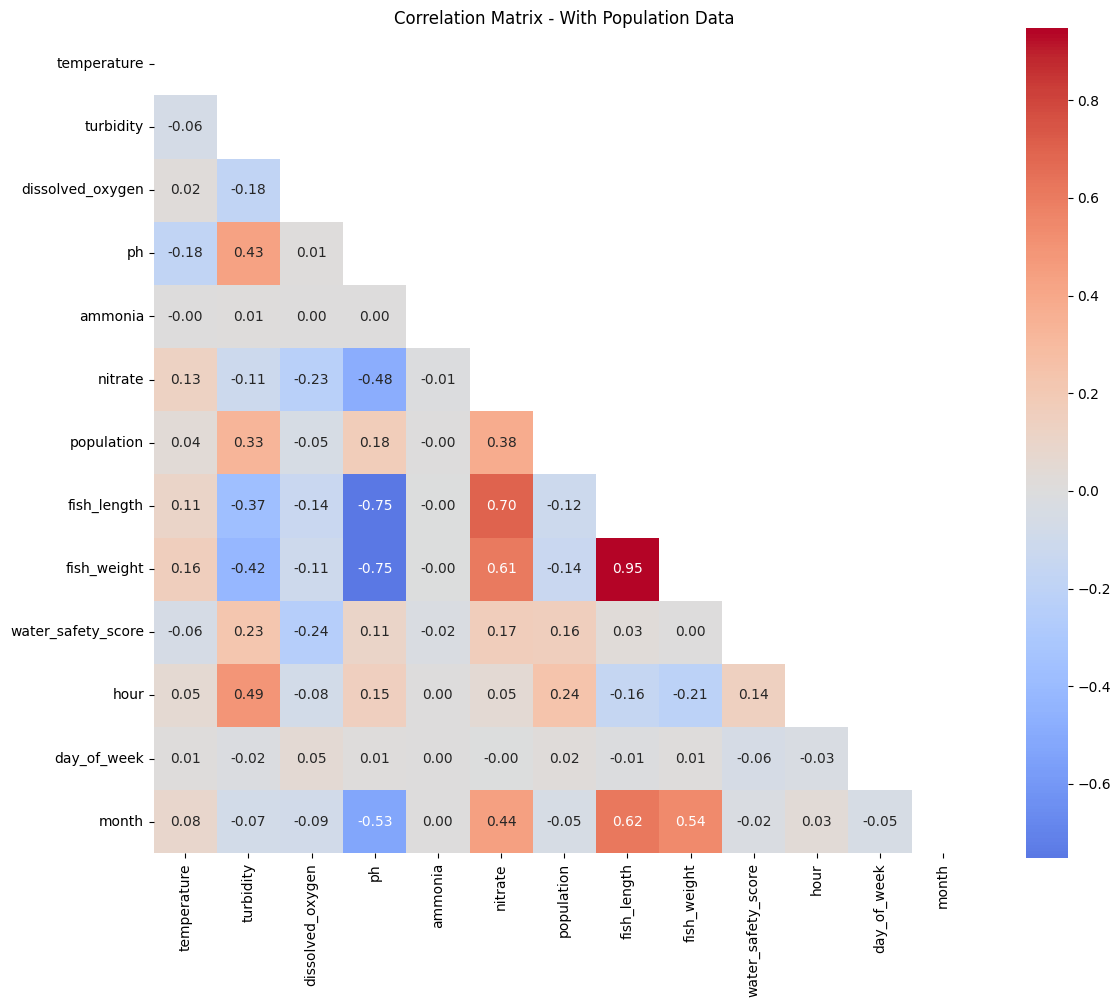


POPULATION CORRELATION ANALYSIS
Correlations with Population:
population: 1.000
nitrate: 0.382
turbidity: 0.326
hour: 0.243
ph: 0.176
water_safety_score: 0.162
temperature: 0.038
day_of_week: 0.020
ammonia: -0.001
dissolved_oxygen: -0.047
month: -0.054
fish_length: -0.119
fish_weight: -0.137

Strong correlations with population (|r| > 0.3): 2
  nitrate: 0.382
  turbidity: 0.326

CORRELATIONS WITHOUT POPULATION


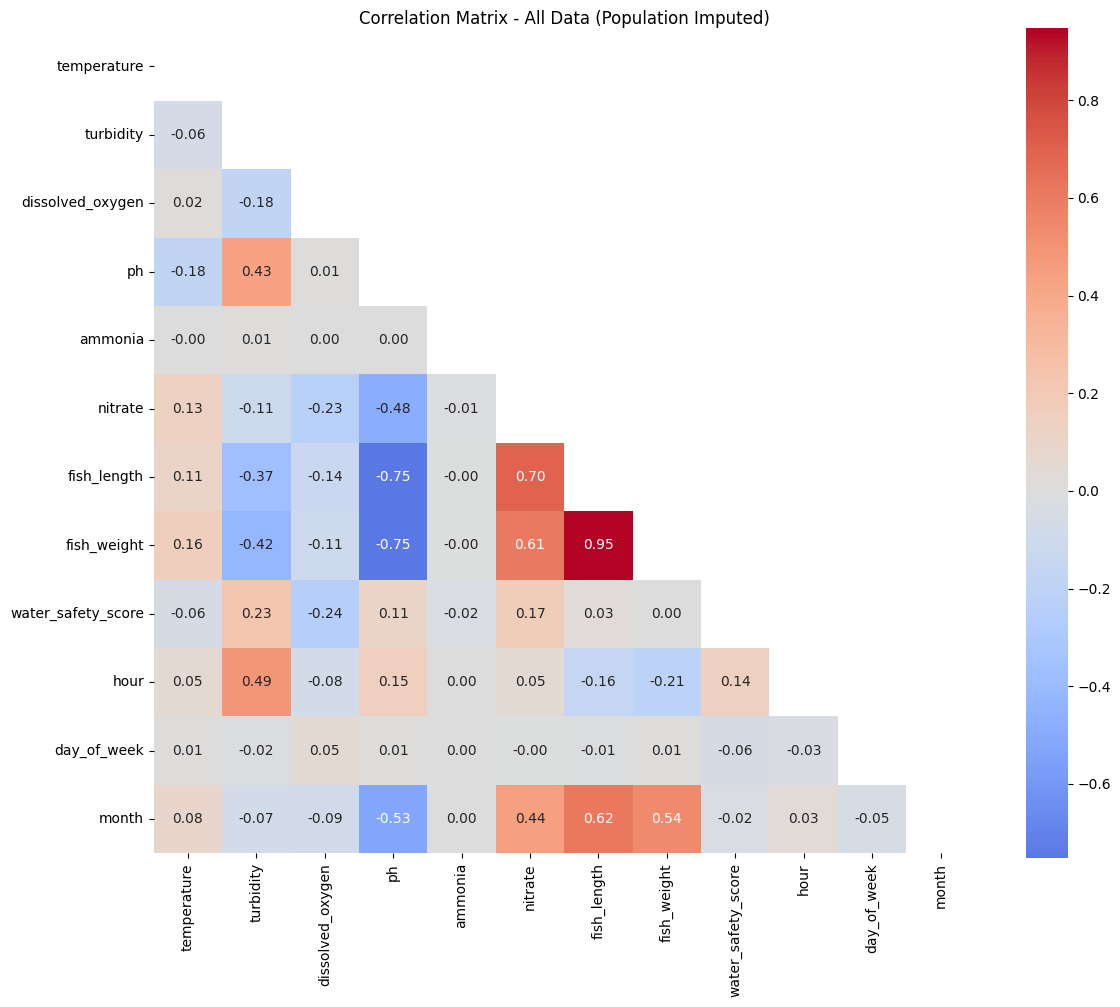


CORRELATION MATRIX COMPARISON:
Maximum absolute difference in correlations:
0.000

Average absolute difference in correlations:
0.000


In [9]:
# Fix the syntax warning by using proper escape or raw string
df_with_pop=df.copy()
df_without_pop=df.drop(columns=["population"])
print(f"\nDATASET SIZES")
print(f"Dataset with population: {len(df_with_pop)} rows")
print(f"Dataset without population: {len(df_without_pop)} rows")

# Simple correlation function without scikit-learn
def simple_analyze_correlations(data, title, columns_to_include=None):
    if columns_to_include is None:
        numeric_cols = data.select_dtypes(include=[np.number]).columns
        numeric_cols = [col for col in numeric_cols if col not in ['entry_id', 'source_df']]
    else:
        numeric_cols = columns_to_include
    
    corr_data = data[numeric_cols].copy()
    
    # Handle infinite values
    corr_data = corr_data.replace([np.inf, -np.inf], np.nan)
    
    # Simple imputation using median
    corr_data_imputed = corr_data.fillna(corr_data.median())
    
    # Calculate correlation matrix
    correlation_matrix = corr_data_imputed.corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.2f',
                square=True)
    plt.title(f'Correlation Matrix - {title}')
    plt.tight_layout()
    plt.show()
    
    return correlation_matrix

# First, let's check for infinite values and clean the data
print("CHECKING FOR DATA ISSUES")
print("Checking for infinite values in the main dataset")
if np.any(np.isinf(df.select_dtypes(include=[np.number]))):
    print("Found infinite values in main dataset. Cleaning")
    df = df.replace([np.inf, -np.inf], np.nan)

print("Checking for infinite values in df_with_pop")
if np.any(np.isinf(df_with_pop.select_dtypes(include=[np.number]))):
    print("Found infinite values in df_with_pop. Cleaning")
    df_with_pop = df_with_pop.replace([np.inf, -np.inf], np.nan)

print("Checking for infinite values in df_without_pop")
if np.any(np.isinf(df_without_pop.select_dtypes(include=[np.number]))):
    print("Found infinite values in df_without_pop. Cleaning")
    df_without_pop = df_without_pop.replace([np.inf, -np.inf], np.nan)

# Let's also check the basic statistics to identify problematic columns
print("\nBASIC STATISTICS FOR NUMERIC COLUMNS:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col not in ['entry_id', 'source_df']:
        print(f"\n{col}:")
        print(f"  Min: {df[col].min():.6f}")
        print(f"  Max: {df[col].max():.6f}")
        print(f"  Mean: {df[col].mean():.6f}")
        print(f"  Nulls: {df[col].isnull().sum()}")

# Define the columns we want to analyze
numeric_cols_with_pop = ['temperature', 'turbidity', 'dissolved_oxygen', 'ph', 
                        'ammonia', 'nitrate', 'population', 'fish_length', 
                        'fish_weight', 'water_safety_score', 'hour', 'day_of_week', 'month']

# Make sure all columns exist in the dataframe
available_cols = [col for col in numeric_cols_with_pop if col in df_with_pop.columns]
print(f"\nAvailable columns for correlation: {available_cols}")

# Analyze correlations for the complete dataset (with population)
print("\nCORRELATIONS WITH POPULATION")
corr_with_pop = simple_analyze_correlations(df_with_pop, "With Population Data", available_cols)

# Analyze population correlations specifically
print("\nPOPULATION CORRELATION ANALYSIS")
if 'population' in corr_with_pop.columns:
    population_correlations = corr_with_pop['population'].sort_values(ascending=False)
    print("Correlations with Population:")
    for feature, corr_value in population_correlations.items():
        print(f"{feature}: {corr_value:.3f}")

    # Check if population is strongly correlated with any other features
    strong_correlations = population_correlations[(abs(population_correlations) > 0.3) & 
                                                (population_correlations != 1.0)]
    print(f"\nStrong correlations with population (|r| > 0.3): {len(strong_correlations)}")
    for feature, corr_value in strong_correlations.items():
        print(f"  {feature}: {corr_value:.3f}")
else:
    print("Population column not found in correlation matrix")
    strong_correlations = []

# Analyze dataset without population for comparison
print("\nCORRELATIONS WITHOUT POPULATION")
numeric_cols_without_pop = [col for col in numeric_cols_with_pop if col != 'population' and col in df.columns]
corr_without_pop = simple_analyze_correlations(df, "All Data (Population Imputed)", numeric_cols_without_pop)

# Compare the two correlation matrices
print("\nCORRELATION MATRIX COMPARISON:")
common_columns = [col for col in numeric_cols_without_pop if col in corr_with_pop.columns and col in corr_without_pop.columns]
if common_columns:
    corr_diff = corr_with_pop.loc[common_columns, common_columns] - corr_without_pop.loc[common_columns, common_columns]
    print("Maximum absolute difference in correlations:")
    print(f"{corr_diff.abs().max().max():.3f}")
    
    print("\nAverage absolute difference in correlations:")
    print(f"{corr_diff.abs().mean().mean():.3f}")
else:
    print("No common columns for comparison")

In [10]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
df['population_imputed_sklearn'] = imputer.fit_transform(df[['population']])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 905803 entries, 763966 to 899796
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   timestamp                   905803 non-null  datetime64[ns]
 1   entry_id                    905803 non-null  float64       
 2   temperature                 905803 non-null  float64       
 3   turbidity                   905803 non-null  float64       
 4   dissolved_oxygen            905803 non-null  float64       
 5   ph                          905803 non-null  float64       
 6   ammonia                     897069 non-null  float64       
 7   nitrate                     905803 non-null  float64       
 8   population                  612530 non-null  float64       
 9   fish_length                 905802 non-null  float64       
 10  fish_weight                 905803 non-null  float64       
 11  water_safety_score          905803 non-

In [12]:
df['ammonia_imputed_sklearn'] = imputer.fit_transform(df[['ammonia']])
df['fish_length_imputed_sklearn'] = imputer.fit_transform(df[['fish_length']])

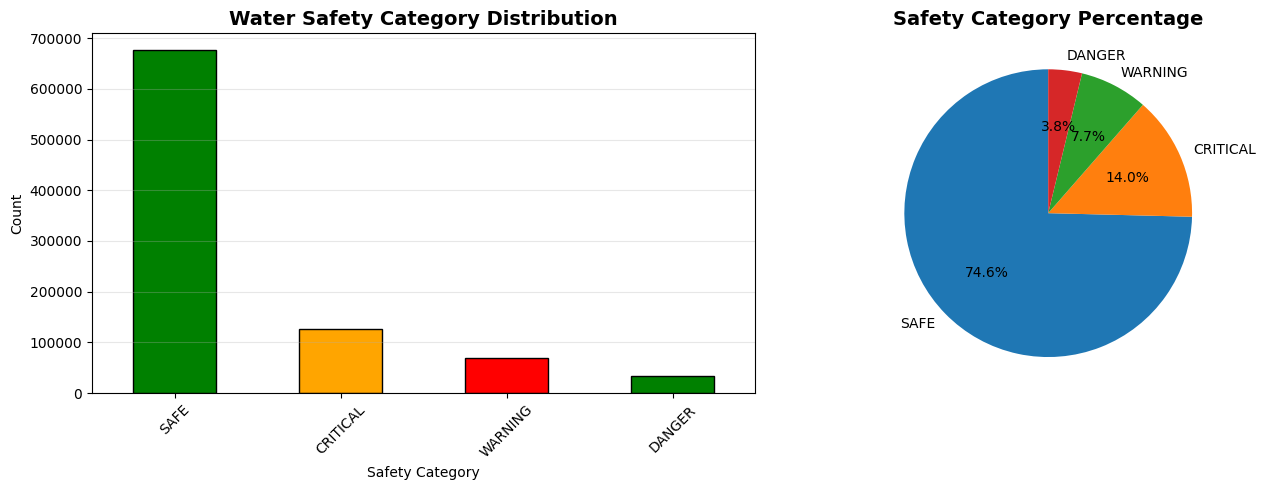

Safety Category Distribution:
safety_category
SAFE        675775
CRITICAL    126457
WARNING      69332
DANGER       34239
Name: count, dtype: int64


In [13]:
#water safety distribution
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
safety_counts = df['safety_category'].value_counts()
safety_counts.plot(kind='bar', color=['green', 'orange', 'red'], edgecolor='black')
plt.title('Water Safety Category Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Safety Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.pie(safety_counts, labels=safety_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Safety Category Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('water_safety_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("Safety Category Distribution:")
print(safety_counts)

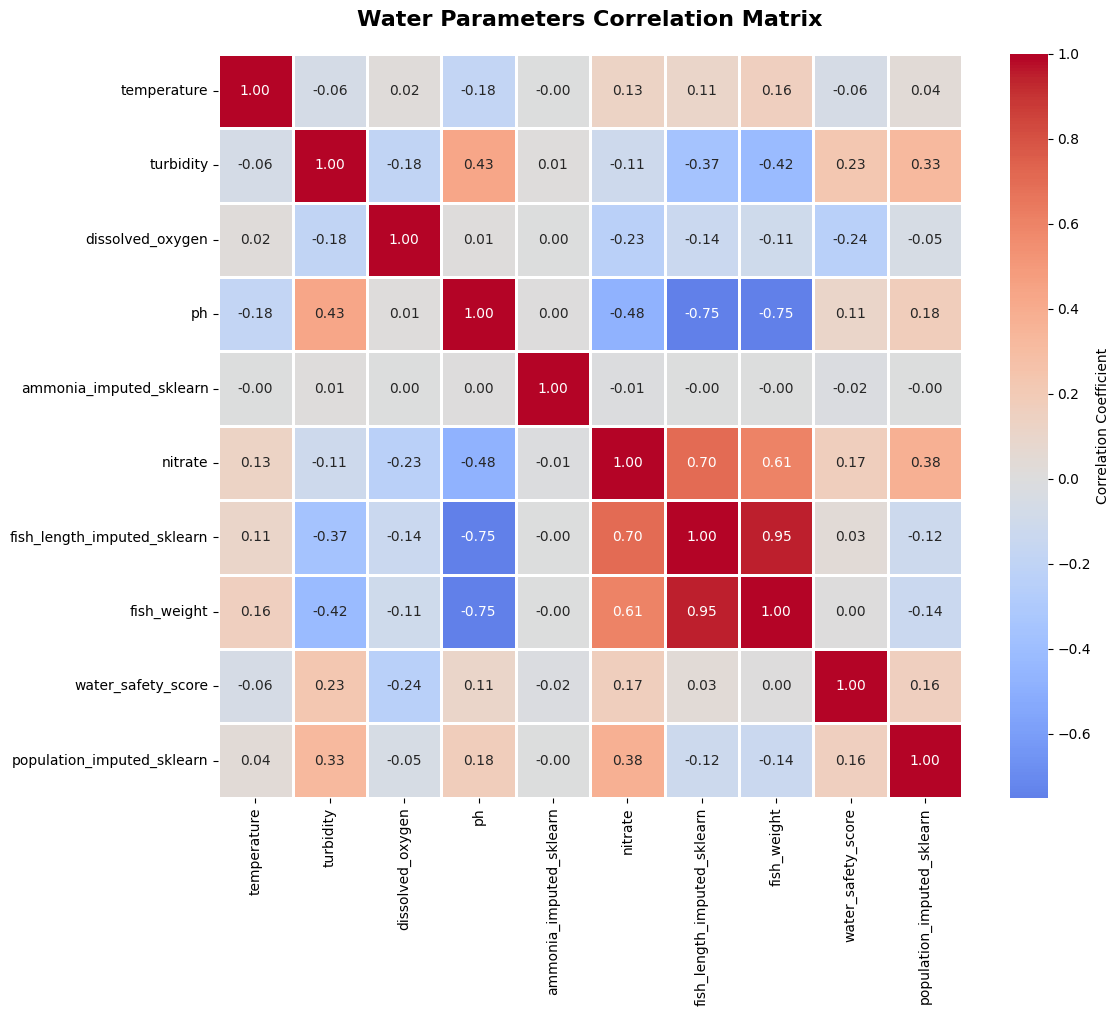

Top correlations with water_safety_score:
water_safety_score             1.000000
turbidity                      0.228617
nitrate                        0.166864
population_imputed_sklearn     0.161838
ph                             0.108111
fish_length_imputed_sklearn    0.031839
fish_weight                    0.002030
ammonia_imputed_sklearn       -0.023858
temperature                   -0.059723
dissolved_oxygen              -0.240135
Name: water_safety_score, dtype: float64


In [14]:
numeric_cols = ['temperature', 'turbidity', 'dissolved_oxygen', 'ph', 
                'ammonia_imputed_sklearn', 'nitrate', 'fish_length_imputed_sklearn', 'fish_weight', 
                'water_safety_score', 'population_imputed_sklearn']

correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Water Parameters Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("Top correlations with water_safety_score:")
correlations = correlation_matrix['water_safety_score'].sort_values(ascending=False)
print(correlations)

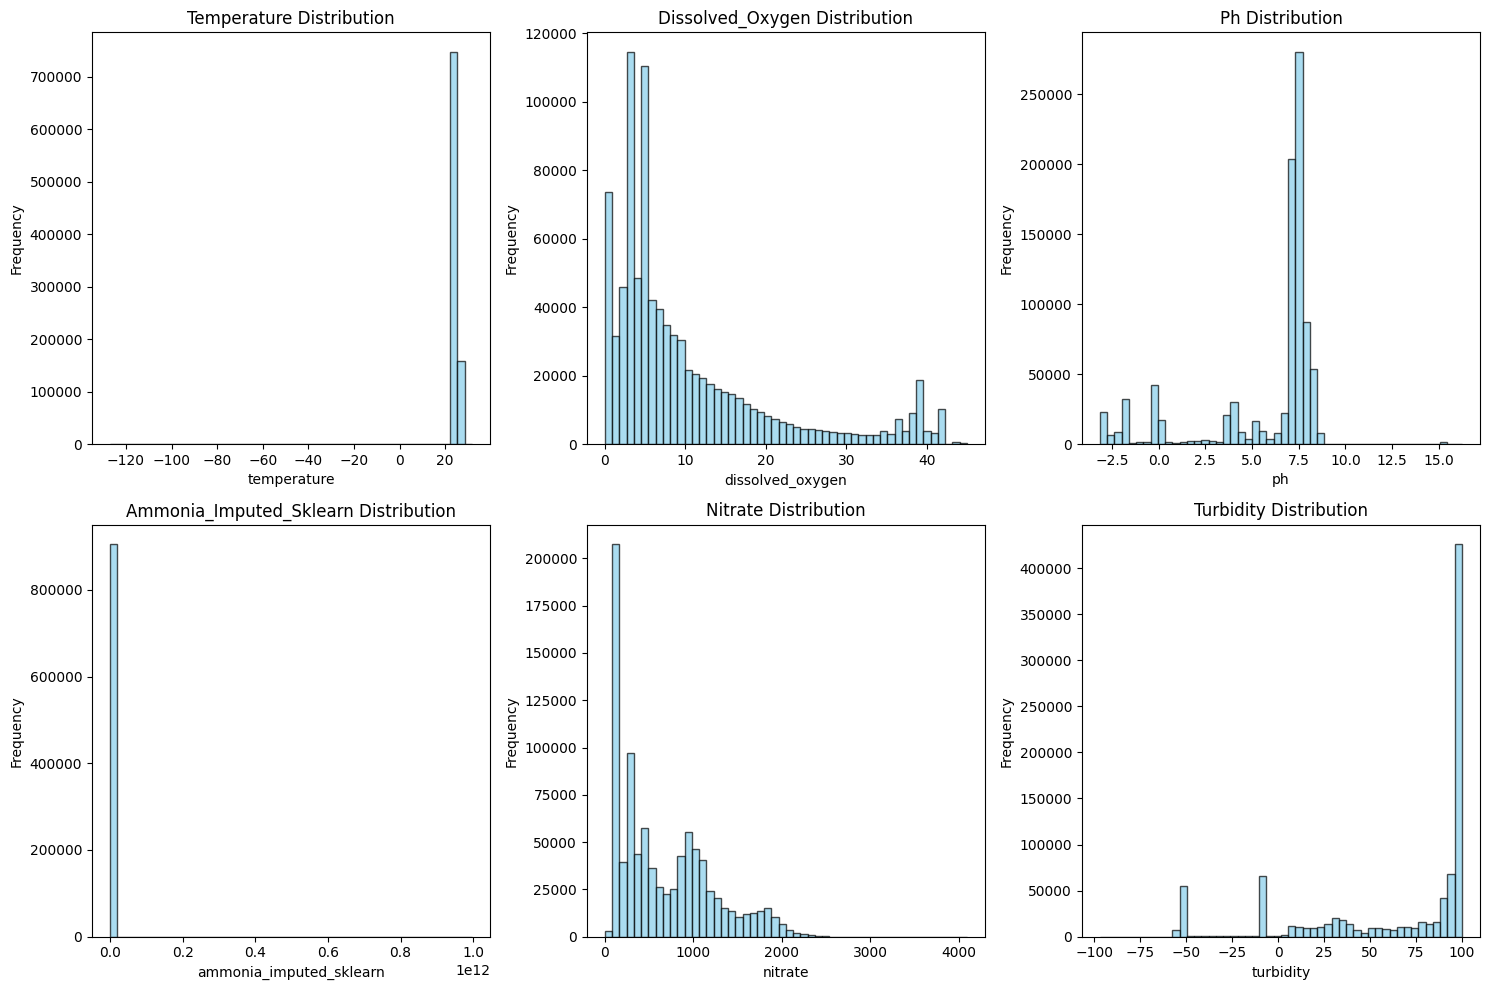

In [15]:
#water quality distribution
plt.style.use('default')
sns.set_palette("husl")

# Key water quality parameters
water_params = ['temperature', 'dissolved_oxygen', 'ph', 'ammonia_imputed_sklearn', 'nitrate', 'turbidity']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, param in enumerate(water_params):
    if param in df.columns:
        axes[i].hist(df[param], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i].set_title(f'{param.title()} Distribution')
        axes[i].set_xlabel(param)
        axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

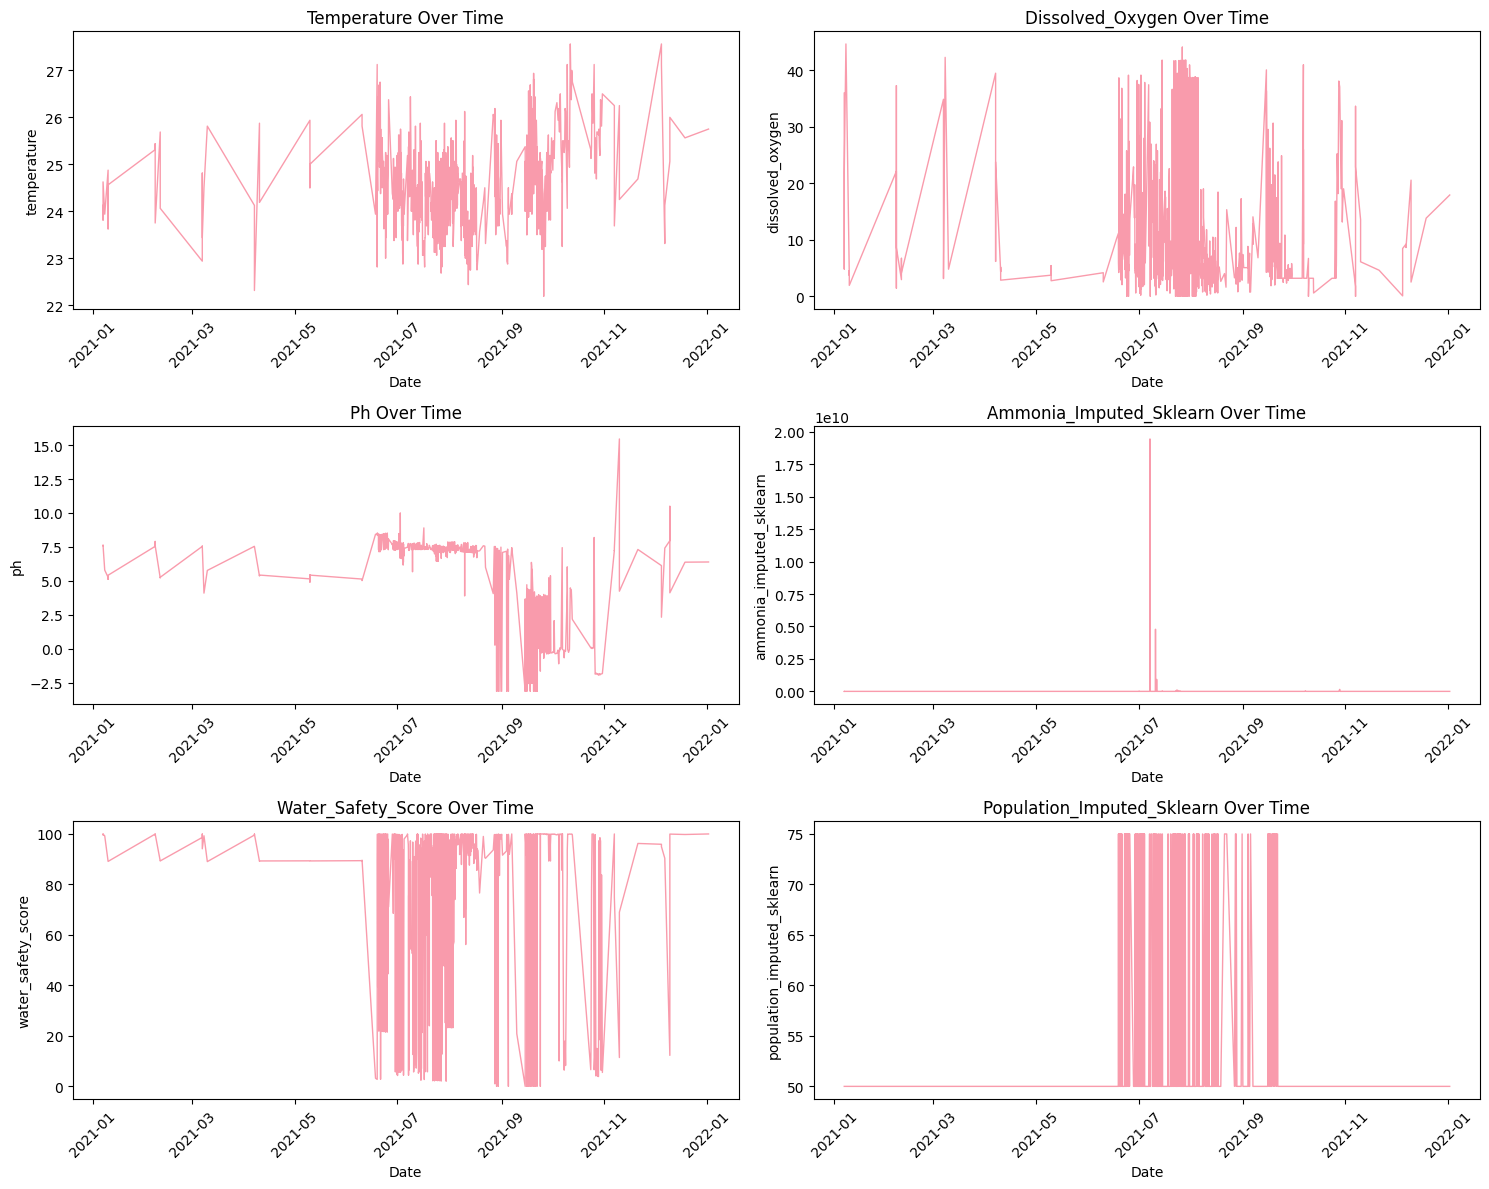

In [16]:
#Time series trend
# Sample data to avoid overcrowding
df_sampled = df.iloc[::1000]  # Every 1000th point

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
trend_params = ['temperature', 'dissolved_oxygen', 'ph', 'ammonia_imputed_sklearn', 'water_safety_score', 'population_imputed_sklearn']

for i, param in enumerate(trend_params):
    if param in df_sampled.columns:
        row, col = i // 2, i % 2
        axes[row, col].plot(df_sampled['timestamp'], df_sampled[param], alpha=0.7, linewidth=1)
        axes[row, col].set_title(f'{param.title()} Over Time')
        axes[row, col].set_xlabel('Date')
        axes[row, col].set_ylabel(param)
        axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

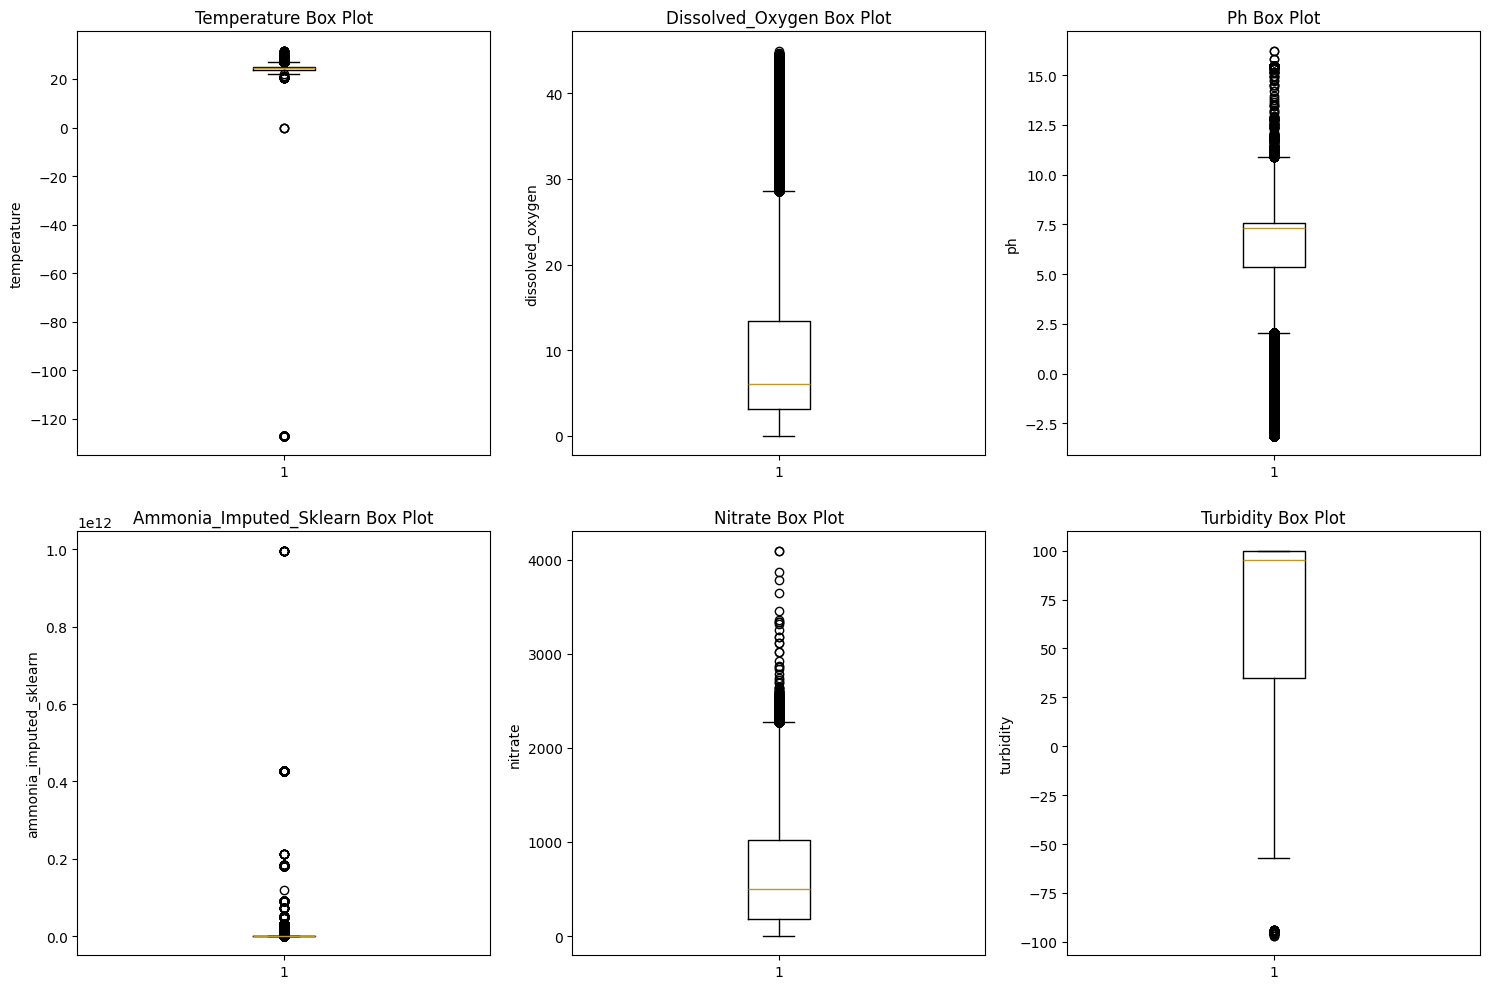

In [17]:
#Outlier Detection
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
box_params = ['temperature', 'dissolved_oxygen', 'ph', 'ammonia_imputed_sklearn', 'nitrate', 'turbidity']

for i, param in enumerate(box_params):
    if param in df.columns:
        df_box = df[[param]].dropna()
        axes[i//3, i%3].boxplot(df_box[param])
        axes[i//3, i%3].set_title(f'{param.title()} Box Plot')
        axes[i//3, i%3].set_ylabel(param)

plt.tight_layout()
plt.show()

In [18]:
df.columns

Index(['timestamp', 'entry_id', 'temperature', 'turbidity', 'dissolved_oxygen',
       'ph', 'ammonia', 'nitrate', 'population', 'fish_length', 'fish_weight',
       'water_safety_score', 'safety_category', 'source_df', 'hour',
       'day_of_week', 'day_name', 'month', 'month_name', 'date', 'year',
       'population_imputed_sklearn', 'ammonia_imputed_sklearn',
       'fish_length_imputed_sklearn'],
      dtype='object')

In [19]:
final_data=df.drop(columns=["source_df","population","ammonia","entry_id","fish_length","timestamp"])

In [20]:
final_data.columns

Index(['temperature', 'turbidity', 'dissolved_oxygen', 'ph', 'nitrate',
       'fish_weight', 'water_safety_score', 'safety_category', 'hour',
       'day_of_week', 'day_name', 'month', 'month_name', 'date', 'year',
       'population_imputed_sklearn', 'ammonia_imputed_sklearn',
       'fish_length_imputed_sklearn'],
      dtype='object')

In [21]:
final_data.to_csv("training_pond_data.csv")

In [2]:
pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ---------------------------- ----------- 1.0/1.5 MB 3.4 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 3.2 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

final_data=pd.read_csv("training_pond_data.csv")
#drop safety scoreto avoid feature leakage
final_data=final_data.drop(columns=["water_safety_score"])
# Prepare features and target
X = final_data.drop(['safety_category', 'day_name', 'month_name', 'date'], axis=1)  # Remove non-numeric columns
y = final_data['safety_category']

print(f"Features shape: {X.shape}")
print(f"Target classes: {y.unique()}")
print(f"Class distribution:\n{y.value_counts()}")

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Encoded classes: {dict(zip(le.classes_, range(len(le.classes_))))}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Scale features (only for models that need it)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(random_state=42, n_jobs=-1, max_iter=1000)
}

# Train and evaluate models
results = {}
trained_models = {}

print("Model performance comparison")
for name, model in models.items():
    print(f"\n--- {name} ---")
    
    # Train model (only scale for Logistic Regression)
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, n_jobs=-1)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    results[name] = {
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    trained_models[name] = model
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Cross-validation: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Detailed classification report for good performing models
    if accuracy > 0.80:  # Lowered threshold to see more reports
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=le.classes_))

# Compare results
print("Final model comparison")
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('accuracy', ascending=False)
print(results_df.round(4))

# Save the best model
best_model_name = results_df.index[0]
best_model = trained_models[best_model_name]

# Create models directory
import os
os.makedirs('aquaculture_models', exist_ok=True)

# Save the best model and preprocessors
joblib.dump(best_model, f'aquaculture_models/best_classification_model.pkl')
joblib.dump(scaler, 'aquaculture_models/scaler.pkl')
joblib.dump(le, 'aquaculture_models/label_encoder.pkl')

print(f"\nSaved best model: {best_model_name}")
print(f"Accuracy: {results_df.iloc[0]['accuracy']:.4f}")

Features shape: (905803, 14)
Target classes: ['SAFE' 'CRITICAL' 'WARNING' 'DANGER']
Class distribution:
safety_category
SAFE        675775
CRITICAL    126457
WARNING      69332
DANGER       34239
Name: count, dtype: int64
Encoded classes: {'CRITICAL': 0, 'DANGER': 1, 'SAFE': 2, 'WARNING': 3}
Training set: (724642, 14), Test set: (181161, 14)
Model performance comparison

--- Random Forest ---
Accuracy: 0.9976
Cross-validation: 0.9974 (+/- 0.0003)

Classification Report:
              precision    recall  f1-score   support

    CRITICAL       1.00      1.00      1.00     25292
      DANGER       0.99      0.99      0.99      6848
        SAFE       1.00      1.00      1.00    135155
     WARNING       0.99      0.98      0.99     13866

    accuracy                           1.00    181161
   macro avg       0.99      0.99      0.99    181161
weighted avg       1.00      1.00      1.00    181161


--- XGBoost ---
Accuracy: 0.9967
Cross-validation: 0.9967 (+/- 0.0004)

Classification Re

Data shape: (905803, 14)
Target distribution:
safety_category
SAFE        675775
CRITICAL    126457
WARNING      69332
DANGER       34239
Name: count, dtype: int64
Plotting learning curve for saved model...
  Training Score: 1.0000
  Validation Score: 0.9972
  Performance Gap: 0.0028
REASONABLE PERFORMANCE GAP


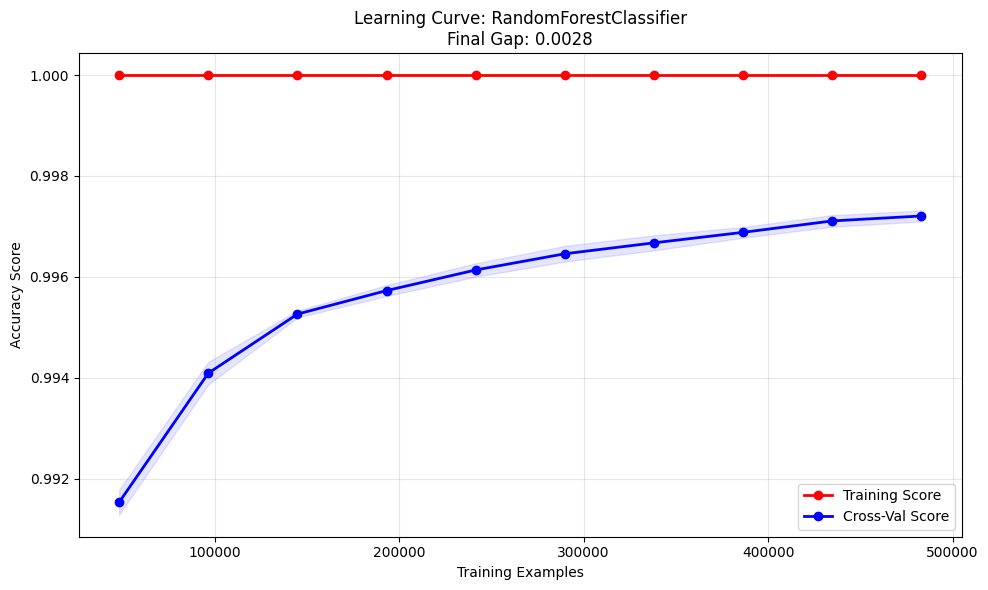

np.float64(0.002793103556882781)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import joblib

final_data = pd.read_csv("training_pond_data.csv")
final_data=final_data.drop(columns=["water_safety_score"])
X = final_data.drop(['safety_category', 'day_name', 'month_name', 'date'], axis=1, errors='ignore')
y = final_data['safety_category']

print(f"Data shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

best_model = joblib.load('aquaculture_models/best_classification_model.pkl')
scaler = joblib.load('aquaculture_models/scaler.pkl')
le = joblib.load('aquaculture_models/label_encoder.pkl')


y_encoded = le.transform(y) 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

def plot_learning_curve_saved_model():
    plt.figure(figsize=(10, 6))
    
    print("Plotting learning curve for saved model...")
    
    train_sizes, train_scores, test_scores = learning_curve(
        best_model, X_train, y_train, cv=3, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy', random_state=42
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="red")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="blue")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="red", 
             label="Training Score", linewidth=2)
    plt.plot(train_sizes, test_scores_mean, 'o-', color="blue", 
             label="Cross-Val Score", linewidth=2)
    
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy Score")
    plt.title(f"Learning Curve: {type(best_model).__name__}\n"
              f"Final Gap: {train_scores_mean[-1] - test_scores_mean[-1]:.4f}")
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)
    
    # Print gap analysis
    final_gap = train_scores_mean[-1] - test_scores_mean[-1]
    print(f"  Training Score: {train_scores_mean[-1]:.4f}")
    print(f"  Validation Score: {test_scores_mean[-1]:.4f}")
    print(f"  Performance Gap: {final_gap:.4f}")
    
    if final_gap > 0.02:
        print("POTENTIAL OVERFITTING (Gap > 0.02)")
    else:
        print("REASONABLE PERFORMANCE GAP")
    
    plt.tight_layout()
    plt.show()
    
    return final_gap

plot_learning_curve_saved_model()

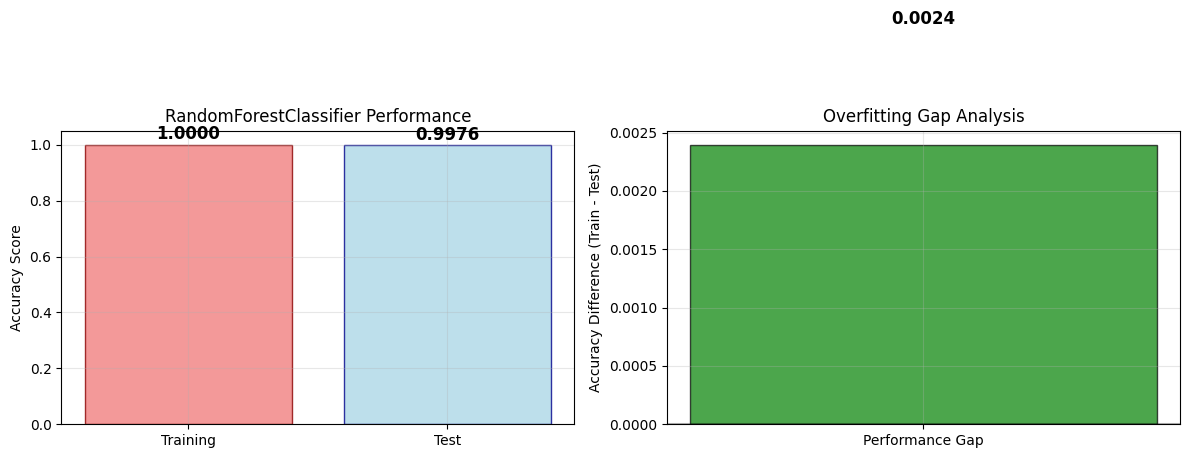


Performance Analysis for RandomForestClassifier:
  Training Accuracy: 1.0000
  Test Accuracy:     0.9976
  Performance Gap:   0.0024


In [6]:
def plot_train_test_comparison():
    # Get predictions from the loaded model
    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)
    
    train_score = accuracy_score(y_train, train_pred)
    test_score = accuracy_score(y_test, test_pred)
    performance_gap = train_score - test_score
    
    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Performance comparison
    scores = [train_score, test_score]
    labels = ['Training', 'Test']
    colors = ['lightcoral', 'lightblue']
    
    bars = ax1.bar(labels, scores, color=colors, edgecolor=['darkred', 'darkblue'], alpha=0.8)
    ax1.set_ylabel('Accuracy Score')
    ax1.set_title(f'{type(best_model).__name__} Performance')
    ax1.set_ylim(0, 1.05)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{score:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Gap analysis
    gap_color = 'red' if performance_gap > 0.02 else 'green'
    ax2.bar(['Performance Gap'], [performance_gap], color=gap_color, alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Accuracy Difference (Train - Test)')
    ax2.set_title('Overfitting Gap Analysis')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.grid(True, alpha=0.3)
    
    # Add value label on gap bar
    ax2.text(0, performance_gap + 0.001 if performance_gap >= 0 else performance_gap - 0.002,
            f'{performance_gap:.4f}', ha='center', va='bottom' if performance_gap >= 0 else 'top', 
            fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print(f"\nPerformance Analysis for {type(best_model).__name__}:")
    print(f"  Training Accuracy: {train_score:.4f}")
    print(f"  Test Accuracy:     {test_score:.4f}")
    print(f"  Performance Gap:   {performance_gap:.4f}")
    
plot_train_test_comparison()

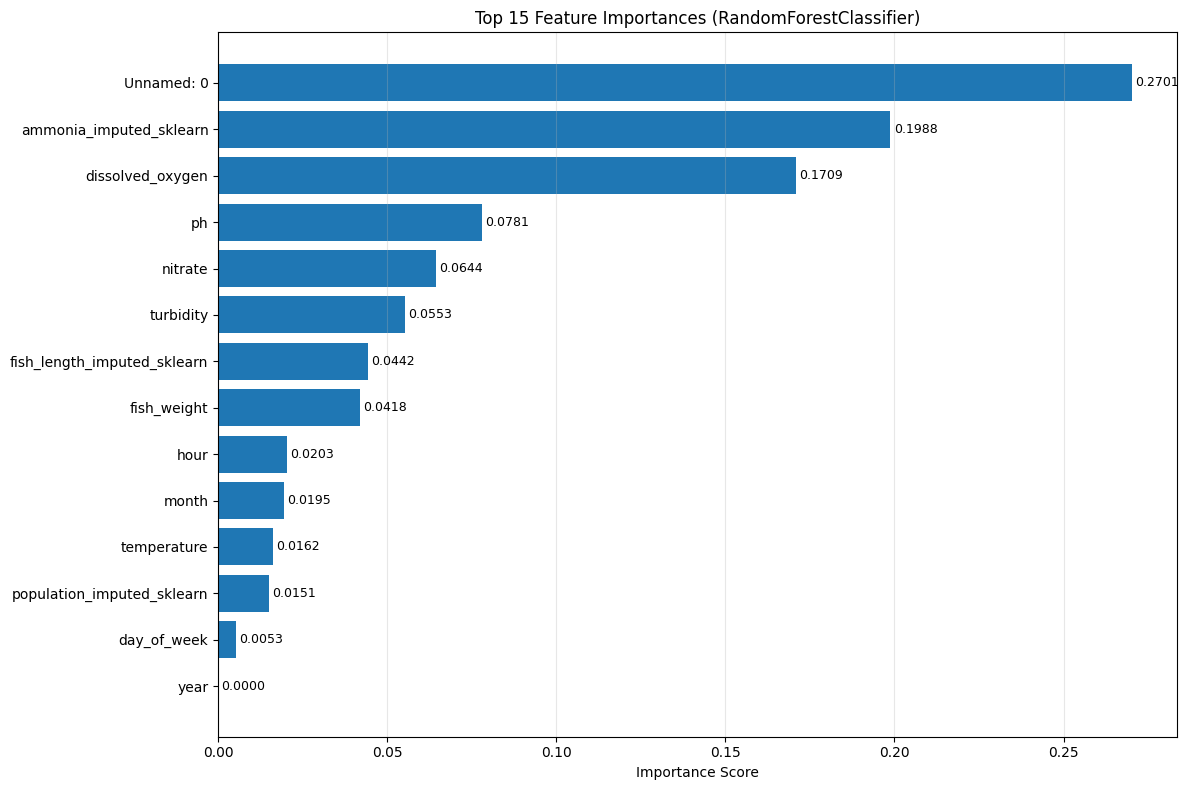

Top 10 Most Important Features:
                        feature  importance
0                    Unnamed: 0      0.2701
12      ammonia_imputed_sklearn      0.1988
3              dissolved_oxygen      0.1709
4                            ph      0.0781
5                       nitrate      0.0644
2                     turbidity      0.0553
13  fish_length_imputed_sklearn      0.0442
6                   fish_weight      0.0418
7                          hour      0.0203
9                         month      0.0195


In [7]:
def plot_feature_importance():
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(12, 8))
        bars = plt.barh(feature_importance['feature'][:15], 
                       feature_importance['importance'][:15])
        plt.xlabel('Importance Score')
        plt.title(f'Top 15 Feature Importances ({type(best_model).__name__})')
        plt.gca().invert_yaxis()
        
        # Add value labels
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.001, bar.get_y() + bar.get_height()/2.,
                    f'{width:.4f}', ha='left', va='center', fontsize=9)
        
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
        
        print("Top 10 Most Important Features:")
        print(feature_importance.head(10).round(4))
        
        # Check for feature dominance
        max_importance = feature_importance['importance'].max()
        if max_importance > 0.5:
            dominant_feature = feature_importance.iloc[0]['feature']
            print(f"Feature dominance detected: '{dominant_feature}' has {max_importance:.3f} importance")
    else:
        print("Feature importance not available for this model type")

plot_feature_importance()

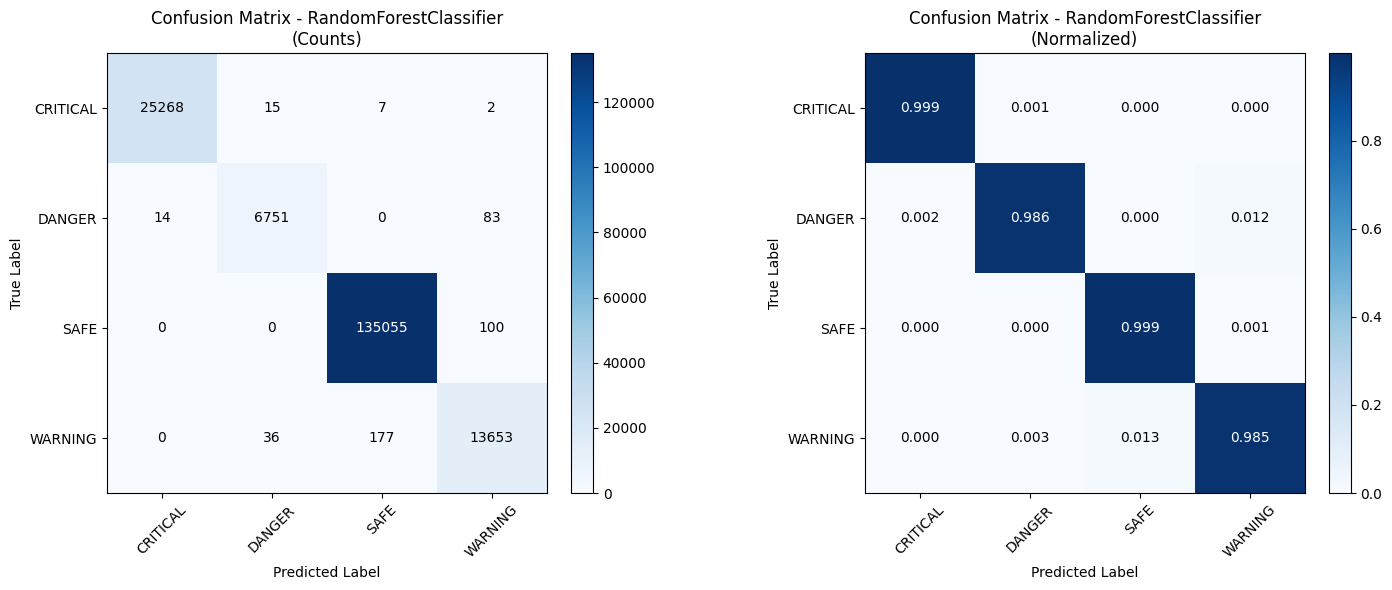


Error Analysis:
  CRITICAL  : 0.999 accuracy, 0.001 error rate
  DANGER    : 0.986 accuracy, 0.014 error rate
  SAFE      : 0.999 accuracy, 0.001 error rate


In [8]:
def plot_confusion_matrix():
    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    im1 = ax1.imshow(cm, cmap='Blues', interpolation='nearest')
    ax1.set_title(f'Confusion Matrix - {type(best_model).__name__}\n(Counts)')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    ax1.set_xticks(range(len(le.classes_)))
    ax1.set_yticks(range(len(le.classes_)))
    ax1.set_xticklabels(le.classes_, rotation=45)
    ax1.set_yticklabels(le.classes_)
    
    # Add text annotations
    for i in range(len(le.classes_)):
        for j in range(len(le.classes_)):
            ax1.text(j, i, f'{cm[i, j]}', 
                    ha="center", va="center", 
                    color="white" if cm[i, j] > cm.max()/2 else "black")
    
    # Plot normalized confusion matrix
    im2 = ax2.imshow(cm_normalized, cmap='Blues', interpolation='nearest')
    ax2.set_title(f'Confusion Matrix - {type(best_model).__name__}\n(Normalized)')
    ax2.set_ylabel('True Label')
    ax2.set_xlabel('Predicted Label')
    ax2.set_xticks(range(len(le.classes_)))
    ax2.set_yticks(range(len(le.classes_)))
    ax2.set_xticklabels(le.classes_, rotation=45)
    ax2.set_yticklabels(le.classes_)
    
    # Add text annotations for normalized
    for i in range(len(le.classes_)):
        for j in range(len(le.classes_)):
            ax2.text(j, i, f'{cm_normalized[i, j]:.3f}', 
                    ha="center", va="center", 
                    color="white" if cm_normalized[i, j] > 0.5 else "black")
    
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
    
    # Print error analysis
    print("\nError Analysis:")
    for i, class_name in enumerate(le.classes_):
        accuracy = cm_normalized[i, i]
        errors = 1 - accuracy
        print(f"  {class_name:10}: {accuracy:.3f} accuracy, {errors:.3f} error rate")

plot_confusion_matrix()

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
import joblib
import warnings
warnings.filterwarnings('ignore')


# Load data
final_data = pd.read_csv("training_pond_data.csv")
# Drop safety category and non-numeric columns for regression
final_data_reg = final_data.drop(['safety_category', 'day_name', 'month_name', 'date'], axis=1, errors='ignore')

In [4]:
# REGRESSION: PREDICTING WATER SAFETY SCORE
print("1. REGRESSION: PREDICTING WATER SAFETY SCORE")
# Prepare features and target for regression
X_reg = final_data_reg.drop(['water_safety_score'], axis=1)  # Features
y_reg = final_data_reg['water_safety_score']  # Target

print(f"Regression features: {X_reg.shape[1]}")
print(f"Target range: {y_reg.min():.2f} to {y_reg.max():.2f}")

# Split data for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print(f"Training set: {X_train_reg.shape}, Test set: {X_test_reg.shape}")

# Scale features for regression
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# Define FAST regression models
regression_models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Linear Regression': LinearRegression(n_jobs=-1),
    'Ridge Regression': Ridge(random_state=42)
}

# Train and evaluate regression models
regression_results = {}
trained_regression_models = {}

for name, model in regression_models.items():    
    # Train model (scale for linear models)
    if name in ['Linear Regression', 'Ridge Regression']:
        model.fit(X_train_reg_scaled, y_train_reg)
        y_pred_reg = model.predict(X_test_reg_scaled)
        cv_scores = cross_val_score(model, X_train_reg_scaled, y_train_reg, cv=3, scoring='r2', n_jobs=-1)  # Reduced CV for speed
    else:
        model.fit(X_train_reg, y_train_reg)
        y_pred_reg = model.predict(X_test_reg)
        cv_scores = cross_val_score(model, X_train_reg, y_train_reg, cv=3, scoring='r2', n_jobs=-1)  # Reduced CV for speed
    
    # Calculate metrics
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_reg, y_pred_reg)
    r2 = r2_score(y_test_reg, y_pred_reg)
    
    regression_results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'CV_R2_mean': cv_scores.mean(),
        'CV_R2_std': cv_scores.std()
    }
    trained_regression_models[name] = model
    
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Compare regression results
print("REGRESSION MODEL COMPARISON")
regression_results_df = pd.DataFrame(regression_results).T
regression_results_df = regression_results_df.sort_values('R2', ascending=False)
print(regression_results_df.round(4))

# Save the best regression model
best_reg_name = regression_results_df.index[0]
best_reg_model = trained_regression_models[best_reg_name]

# 2. ANOMALY DETECTION FOR SMART MONITORING (FAST VERSION)
print("2. ANOMALY DETECTION FOR SMART MONITORING")

# Use water quality parameters for anomaly detection
water_quality_features = ['temperature', 'turbidity', 'dissolved_oxygen', 'ph', 'ammonia', 'nitrate']
water_quality_features = [col for col in water_quality_features if col in final_data_reg.columns]

print(f"Anomaly detection features: {water_quality_features}")
X_anomaly = final_data_reg[water_quality_features]

print(f"Anomaly data shape: {X_anomaly.shape}")

# Scale features for anomaly detection
scaler_anomaly = StandardScaler()
X_anomaly_scaled = scaler_anomaly.fit_transform(X_anomaly)

# Define FAST anomaly detection models (No SVM)
anomaly_models = {
    'Isolation Forest': IsolationForest(contamination=0.1, random_state=42, n_jobs=-1),
    'Local Outlier Factor': LocalOutlierFactor(n_neighbors=20, contamination=0.1, n_jobs=-1),
    'Elliptic Envelope': EllipticEnvelope(contamination=0.1, random_state=42)
}

# Train and evaluate anomaly detection models
anomaly_results = {}
trained_anomaly_models = {}

for name, model in anomaly_models.items():
    print(f"\n--- {name} ---")
    
    try:
        if name == 'Local Outlier Factor':
            # LOF doesn't have fit method, we use fit_predict
            predictions = model.fit_predict(X_anomaly_scaled)
            # Store model parameters for reference (LOF can't be saved directly)
            trained_anomaly_models[name] = {
                'model_type': 'LOF',
                'n_neighbors': model.n_neighbors,
                'contamination': model.contamination
            }
        else:
            # Other models use original data
            model.fit(X_anomaly)
            predictions = model.predict(X_anomaly)
            trained_anomaly_models[name] = model
        
        # Calculate anomaly statistics
        n_anomalies = (predictions == -1).sum()
        anomaly_percentage = (n_anomalies / len(predictions)) * 100
        
        anomaly_results[name] = {
            'n_anomalies': n_anomalies,
            'anomaly_percentage': anomaly_percentage
        }
        
        print(f"Anomalies detected: {n_anomalies} ({anomaly_percentage:.2f}%)")
            
    except Exception as e:
        print(f"Error with {name}: {e}")
        anomaly_results[name] = {'n_anomalies': 0, 'anomaly_percentage': 0}

# Compare anomaly detection results
print("ANOMALY DETECTION COMPARISON")
anomaly_results_df = pd.DataFrame(anomaly_results).T
print(anomaly_results_df.round(2))

# Select best anomaly detection model (Isolation Forest is usually most robust)
best_anomaly_name = 'Isolation Forest'
if best_anomaly_name in trained_anomaly_models:
    best_anomaly_model = trained_anomaly_models[best_anomaly_name]
    print(f"Best anomaly model: {best_anomaly_name}")
else:
    # Fallback to first available model that can be saved
    available_models = [name for name in trained_anomaly_models.keys() if name != 'Local Outlier Factor']
    if available_models:
        best_anomaly_name = available_models[0]
        best_anomaly_model = trained_anomaly_models[best_anomaly_name]
        print(f"Best available anomaly model: {best_anomaly_name}")
    else:
        print(" No suitable anomaly models available")
        best_anomaly_model = None

# 3. TIME-SERIES FORECASTING PREPARATION
print("3. TIME-SERIES FORECASTING PREPARATION")

# If timestamp is available, prepare for time-series forecasting
if 'timestamp' in final_data.columns:
    print("Timestamp detected - Time-series features created")
    final_data_sorted = final_data.sort_values('timestamp').reset_index(drop=True)
    
    # Add lag features for key parameters
    for col in ['dissolved_oxygen', 'temperature', 'ph']:
        if col in final_data_sorted.columns:
            final_data_sorted[f'{col}_lag1'] = final_data_sorted[col].shift(1)
            final_data_sorted[f'{col}_lag2'] = final_data_sorted[col].shift(2)
    
    print(f"Time-series features added. New shape: {final_data_sorted.shape}")
else:
    print("No timestamp column found - Basic regression models used")

# 4. SAVE ALL MODELS
print("4. SAVING MODELS")

# Create models directory
import os
os.makedirs('pond_water_models', exist_ok=True)

# Save regression model and preprocessors
joblib.dump(best_reg_model, 'pond_water_models/best_regression_model.pkl')
joblib.dump(scaler_reg, 'pond_water_models/regression_scaler.pkl')
print(f"Saved regression model: {best_reg_name}")

# Save anomaly detection model and preprocessors (if available)
if best_anomaly_model is not None and best_anomaly_name != 'Local Outlier Factor':
    joblib.dump(best_anomaly_model, 'pond_water_models/best_anomaly_model.pkl')
    joblib.dump(scaler_anomaly, 'pond_water_models/anomaly_scaler.pkl')
    print(f"Saved anomaly detection model: {best_anomaly_name}")
else:
    print("Anomaly model not saved (LOF cannot be persisted)")

# Save feature information
feature_info = {
    'regression_features': X_reg.columns.tolist(),
    'anomaly_features': water_quality_features,
    'target_name': 'water_safety_score'
}
joblib.dump(feature_info, 'pond_water_models/feature_info.pkl')

1. REGRESSION: PREDICTING WATER SAFETY SCORE
Regression features: 14
Target range: 0.00 to 100.00
Training set: (724642, 14), Test set: (181161, 14)
R²: 0.9996
RMSE: 0.6315
MAE: 0.0684
CV R²: 0.9994 (+/- 0.0001)
R²: 0.9984
RMSE: 1.2767
MAE: 0.6077
CV R²: 0.9982 (+/- 0.0000)
R²: 0.9558
RMSE: 6.7272
MAE: 4.0616
CV R²: 0.9536 (+/- 0.0016)
R²: 0.1479
RMSE: 29.5337
MAE: 22.5785
CV R²: 0.1435 (+/- 0.0011)
R²: 0.1479
RMSE: 29.5337
MAE: 22.5785
CV R²: 0.1435 (+/- 0.0011)
REGRESSION MODEL COMPARISON
                      RMSE      MAE      R2  CV_R2_mean  CV_R2_std
Random Forest       0.6315   0.0684  0.9996      0.9994     0.0001
XGBoost             1.2767   0.6077  0.9984      0.9982     0.0000
Gradient Boosting   6.7272   4.0616  0.9558      0.9536     0.0008
Linear Regression  29.5337  22.5785  0.1479      0.1435     0.0006
Ridge Regression   29.5337  22.5785  0.1479      0.1435     0.0006
2. ANOMALY DETECTION FOR SMART MONITORING
Anomaly detection features: ['temperature', 'turbidity', 'di

['pond_water_models/feature_info.pkl']